## PUGS Kaggle Challenge - Ziad Nader

In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. 

In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).


In [2]:
import numpy as np
import pandas as pd
import re, random, time
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_colwidth = 1000
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV

C:\Users\znader\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Load

In [3]:
train = pd.read_csv("train_V2.csv")
test = pd.read_csv("test_V2.csv")

## Missing Values Check

In [4]:
nan_rows = train[train['winPlacePerc'].isnull()]

In [5]:
train = train.drop(train.index[2744604])

In [25]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,...,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06,4.446965e+06
mean,2.338150e-01,1.106908e+00,1.307172e+02,6.578757e-01,2.268196e-01,1.370148e+00,4.759936e+01,5.050062e+02,9.247835e-01,5.439553e-01,...,1.646590e-01,6.061158e+02,3.496092e-03,4.509323e+00,2.386841e-02,7.918209e-03,1.154218e+03,3.660488e+00,6.064603e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746293e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261158e-02,1.183497e+03,2.456543e+00,7.397005e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.910000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [26]:
train.dtypes

Id                  object
groupId             object
matchId             object
assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

In [6]:
nan_rows

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [6]:
sample = pd.read_csv("sample_submission_V2.csv")

In [7]:
train_size = train.groupby(['matchId','groupId']).size().reset_index(name='group_size')



In [8]:

train_mean = train.groupby(['matchId','groupId']).mean().reset_index()


In [9]:
test_size = test.groupby(['matchId','groupId']).size().reset_index(name='group_size')

In [10]:
test_mean = test.groupby(['matchId','groupId']).mean().reset_index()

In [11]:
train_match_mean = train.groupby(['matchId']).mean().reset_index()
test_match_mean = test.groupby(['matchId']).mean().reset_index()

train = pd.merge(train, train_mean, suffixes=["", "_mean"], how='left', on=['matchId', 'groupId'])
test = pd.merge(test, test_mean, suffixes=["", "_mean"], how='left', on=['matchId', 'groupId'])
del train_mean
del test_mean

train = pd.merge(train, train_match_mean, suffixes=["", "_match_mean"], how='left', on=['matchId'])
test = pd.merge(test, test_match_mean, suffixes=["", "_match_mean"], how='left', on=['matchId'])
del train_match_mean
del test_match_mean

train = pd.merge(train, train_size, how='left', on=['matchId', 'groupId'])
test = pd.merge(test, test_size, how='left', on=['matchId', 'groupId'])
del train_size
del test_size

train_columns = list(test.columns)

In [12]:
train_columns.remove("Id")
train_columns.remove("matchId")
train_columns.remove("groupId")
train_columns.remove("Id_mean")
train_columns.remove("Id_match_mean")

ValueError: list.remove(x): x not in list

In [15]:
train_columns

['assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'matchType',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'assists_mean',
 'boosts_mean',
 'damageDealt_mean',
 'DBNOs_mean',
 'headshotKills_mean',
 'heals_mean',
 'killPlace_mean',
 'killPoints_mean',
 'kills_mean',
 'killStreaks_mean',
 'longestKill_mean',
 'matchDuration_mean',
 'maxPlace_mean',
 'numGroups_mean',
 'rankPoints_mean',
 'revives_mean',
 'rideDistance_mean',
 'roadKills_mean',
 'swimDistance_mean',
 'teamKills_mean',
 'vehicleDestroys_mean',
 'walkDistance_mean',
 'weaponsAcquired_mean',
 'winPoints_mean',
 'assists_match_mean',
 'boosts_match_mean',
 'damageDealt_match_mean',
 'DBNOs_match_mean',
 'headshotKills_match_mean',
 'heals_match_mean',
 'killPlace_match

In [16]:
train_columns_new = []
for name in train_columns:
    if '_' in name:
        train_columns_new.append(name)
train_columns = train_columns_new    

In [17]:
X_train = train[train_columns]
X_test = test[train_columns]

Feature engineering

In [18]:
df_train = X_train

In [19]:
X = df_train
y = train.winPlacePerc

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

np.random.seed(1)
train_rows = np.random.choice(df_train.index, int(len(df_train)* 0.8), replace=False)
valid_rows = [x for x in df_train.index if x not in train_rows]
df_train1 = df_train.loc[train_rows]
df_valid1 = df_train.loc[valid_rows]

train_X = df_train1.drop(['Id', 'groupId', 'matchId'], axis = 1)
train_Y = df_train1.winPlacePerc
valid_X = df_valid1.drop(['Id', 'groupId', 'matchId'], axis = 1)
valid_Y = df_valid1.winPlacePerc

train_X = df_train1.drop(['Id', 'groupId', 'matchId' , 'winPlacePerc'], axis = 1)

valid_X = df_valid1.drop(['Id', 'groupId', 'matchId' , 'winPlacePerc'], axis = 1)

In [21]:
train_X = X_train
train_Y = y_train
valid_X = X_test
valid_Y = y_test

In [22]:
dtrain = xgb.DMatrix(train_X, label=train_Y.values)
dtest = xgb.DMatrix(valid_X , label  = valid_Y.values)
evallist  = [(dtest,'eval'), (dtrain,'train')]

In [23]:
params = {
    'eta': 0.5, 
    'boosting': 'gbtree', 
    'objective': 'reg:logistic', 
    'eval_metric': 'mae', 
    'is_training_metric': False, 
    'scale_pos_weight': 0.5,
    'max_depth': 15,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,
    'seed': 0
}


[0]	eval-mae:0.154599	train-mae:0.154141
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 10 rounds.
[1]	eval-mae:0.096811	train-mae:0.095671
[2]	eval-mae:0.069397	train-mae:0.067664
[3]	eval-mae:0.056649	train-mae:0.054343
[4]	eval-mae:0.050467	train-mae:0.04779
[5]	eval-mae:0.048178	train-mae:0.045169
[6]	eval-mae:0.046035	train-mae:0.042751
[7]	eval-mae:0.044723	train-mae:0.041301
[8]	eval-mae:0.043939	train-mae:0.040381
[9]	eval-mae:0.043457	train-mae:0.039814
[10]	eval-mae:0.042996	train-mae:0.03924
[11]	eval-mae:0.042769	train-mae:0.038917
[12]	eval-mae:0.042426	train-mae:0.0385
[13]	eval-mae:0.041778	train-mae:0.037702
[14]	eval-mae:0.041329	train-mae:0.037063
[15]	eval-mae:0.040842	train-mae:0.036325
[16]	eval-mae:0.040416	train-mae:0.035739
[17]	eval-mae:0.040159	train-mae:0.035346
[18]	eval-mae:0.03994	train-mae:0.03502
[19]	eval-mae:0.039668	train-mae:0.034607
[20]	eval-mae:0.039277	train-mae:

[191]	eval-mae:0.02532	train-mae:0.014098
[192]	eval-mae:0.025275	train-mae:0.014042
[193]	eval-mae:0.025258	train-mae:0.014014
[194]	eval-mae:0.025253	train-mae:0.014007
[195]	eval-mae:0.025203	train-mae:0.013939
[196]	eval-mae:0.025154	train-mae:0.013872
[197]	eval-mae:0.025091	train-mae:0.013796
[198]	eval-mae:0.025024	train-mae:0.01372
[199]	eval-mae:0.024985	train-mae:0.013673
Plot feature importances...


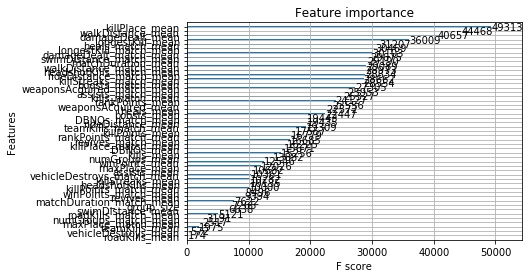

In [24]:
fit_model = xgb.train( params, dtrain , num_boost_round = 200, evals=   evallist , early_stopping_rounds= 10 )
print('Plot feature importances...')
ax = xgb.plot_importance(fit_model)
plt.show()

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [ ]:
best_params = None
num_boost_round = 999
params = {}
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=2,
        metrics={'mae'},
        early_stopping_rounds=10
    )

In [26]:
df_test = test.drop(['Id', 'groupId', 'matchId'  , 'matchType'], axis = 1)

model = xgb.XGBClassifier(objective = 'reg:logistic')
param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16]}
grid_search = RandomizedSearchCV(model , param_distributions= param_dist, cv = 2)

grid_search.fit(X_train, y_train)

In [27]:
X_test = df_test[train_columns]

In [30]:
dtest_X = xgb.DMatrix(X_test)

In [31]:
output_win = fit_model.predict(dtest_X)

In [32]:
output_df = pd.DataFrame( output_win)

In [33]:
sampleID = sample['Id']

In [34]:
t = pd.concat([sampleID , output_df] , axis = 1)

In [35]:
t.columns = ['Id' , 'winPLacePerc']

In [36]:
t.to_csv('Submission_12.csv' , index = False)

## RANDOM FOREST

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [46]:
train_rf = train
test_rf = test

In [47]:
train_rf.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'assists_mean',
       'boosts_mean', 'damageDealt_mean', 'DBNOs_mean', 'headshotKills_mean',
       'heals_mean', 'killPlace_mean', 'killPoints_mean', 'kills_mean',
       'killStreaks_mean', 'longestKill_mean', 'matchDuration_mean',
       'maxPlace_mean', 'numGroups_mean', 'rankPoints_mean', 'revives_mean',
       'rideDistance_mean', 'roadKills_mean', 'swimDistance_mean',
       'teamKills_mean', 'vehicleDestroys_mean', 'walkDistance_mean',
       'weaponsAcquired_mean', 'winPoints_mean', 'winPlacePerc_mean',
       'assists_match_mean', 'boosts_match_mean', 'da

In [48]:
X_train_rf = train[train_columns]
X_test_rf = test[train_columns]

In [49]:
X = X_train_rf
y = train_rf.winPlacePerc

In [50]:
X_train_rf, X_valid_rf, y_train_rf, y_valid_rf = train_test_split(X, y, test_size=0.33, random_state=42)

In [51]:
clf = RandomForestRegressor(max_depth=10, random_state=9  , n_estimators=200 )

In [52]:
clf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=9, verbose=0, warm_start=False)

In [54]:
y_pred = clf.predict(X_valid_rf)

In [55]:
y_pred

array([ 0.45294952,  0.87165249,  0.85311666, ...,  0.70021675,
        0.40392368,  0.8212693 ])

In [56]:
y_valid_rf

4270779    0.2800
1687951    0.8571
3732582    0.7812
3386216    0.1379
243580     0.7263
2919652    0.1923
1834239    0.9091
1830481    0.0000
575185     0.0833
4397206    0.1364
1620825    0.3214
1592232    0.3793
588134     0.5200
3460725    0.0889
1674480    0.5510
729485     0.2759
88735      0.8571
2645472    0.8148
3410202    0.6809
3718448    0.4375
1946380    0.4167
459798     0.6296
2639513    0.8936
3019732    0.9247
4214802    0.0690
2119946    0.3804
1809526    0.5957
3037393    0.6531
1603051    0.7778
221        0.5385
            ...  
397290     0.1327
3300568    0.7308
720004     0.5357
377192     0.1923
2542478    0.0000
1084       0.1724
2116125    0.3333
1778613    0.4231
2864416    0.8980
1810798    0.8846
182367     0.3011
3675359    0.9783
704999     0.6522
3692114    0.0000
2586343    0.9375
3964642    0.9388
1681946    0.0227
1230106    1.0000
2397000    0.9583
405038     1.0000
791533     0.4124
3453559    0.9231
1105696    0.5000
1301696    0.7308
1655968   

In [58]:
output_win_rf = clf.predict(X_test_rf)

In [59]:
output_df_rf = pd.DataFrame( output_win_rf)

In [61]:
t_rf = pd.concat([sampleID , output_df_rf] , axis = 1)

In [62]:
t_rf.columns = ['Id' , 'winPLacePerc']

In [63]:
t_rf.to_csv('Submission_rf.csv' , index = False)

## Random Forest Search CV

In [66]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [69]:
rf = RandomForestRegressor()
rf_random1 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random1.fit(X_train_rf, y_train_rf)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
